In [6]:

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import time
from sklearn.preprocessing import normalize, MinMaxScaler
from tqdm import tqdm

from deepface import DeepFace

from lightphe import LightPHE

try:
    import tenseal as ts
    TENSEAL_AVAILABLE = True
except ImportError:
    print("TenSEAL not available. Please install with: pip install tenseal")
    TENSEAL_AVAILABLE = False

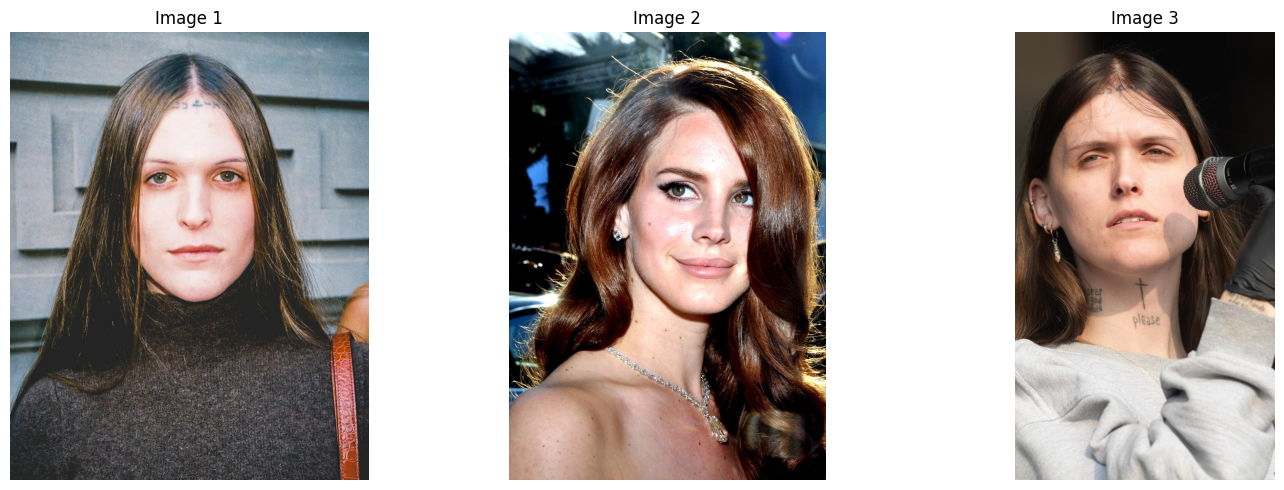

In [18]:
# Cell 2: Setup directories and images
os.makedirs("test_images", exist_ok=True)
os.makedirs("keys", exist_ok=True)

# Helper function to download sample images
def download_sample_images():
    import requests
    
    image_urls = {
        "img1.jpg": "https://scontent.fdad3-1.fna.fbcdn.net/v/t51.75761-15/472904288_18479691505008747_5108622755100274801_n.jpg?stp=dst-jpg_s1080x2048_tt6&_nc_cat=108&ccb=1-7&_nc_sid=127cfc&_nc_ohc=CK5R9XS6rcQQ7kNvwH6nP__&_nc_oc=AdlJRamIM99qE_yRF4sbD8pdEVbmZNIDCUIQbToQHNauRiu932tzSHqpULJvYjqeyuI&_nc_zt=23&_nc_ht=scontent.fdad3-1.fna&_nc_gid=CMqsoC0d4vvPpm5Sa73x-w&oh=00_AfMKoRMzuVw5BbU9A_SGbJCs2SUDe5OsKw7uCCbhEuM04Q&oe=6866DF80",
        "img2.jpg": "https://upload.wikimedia.org/wikipedia/commons/7/71/Lana_Del_Rey_Cannes_2012.jpg",
        "img3.jpg": "https://seatgeekimages.com/performers-landscape/ethel-cain-2c11be/798453/1100x1900.jpg?auto=webp&width=3840&quality=75"
    }
    
    for filename, url in image_urls.items():
        filepath = os.path.join("test_images", filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            response = requests.get(url)
            with open(filepath, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded {filename}")

# Download sample images if they don't exist
download_sample_images()

# Display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, img_file in enumerate(["img1.jpg", "img2.jpg", "img3.jpg"]):
    img_path = os.path.join("test_images", img_file)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [19]:
# Cell 3: Initialize both encryption systems
# Setup PHE (LightPHE)

if TENSEAL_AVAILABLE:
    print("Setting up TenSEAL...")
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
    context.global_scale = 2**40
    context.generate_galois_keys()
    print("TenSEAL context created successfully")
else:
    context = None
    print("TenSEAL not available, skipping FHE setup")

Setting up TenSEAL...
TenSEAL context created successfully


In [9]:
# Cell 4: Testing DeepFace with TenSEAL (FHE) and LightPHE (PHE)
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

# Function to calculate cosine similarity
def cosine_similarity(a, b):
    """Calculate cosine similarity between two vectors"""
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

print("Testing face recognition using VGG-Face with HomomorphicEncryption")
print("-" * 60)

try:
    # Extract VGG-Face embeddings
    print("Extracting VGG-Face embeddings...")
    
    model_name = "VGG-Face"
    detector = "yunet"
    
    # Extract embeddings
    start_time = time.time()
    ethel1_embedding = DeepFace.represent(os.path.join("test_images", "img1.jpg"), 
                                        model_name=model_name, detector_backend=detector)[0]["embedding"]
    ethel2_embedding = DeepFace.represent(os.path.join("test_images", "img3.jpg"), 
                                        model_name=model_name, detector_backend=detector)[0]["embedding"]
    lana_embedding = DeepFace.represent(os.path.join("test_images", "img2.jpg"), 
                                      model_name=model_name, detector_backend=detector)[0]["embedding"]
    extract_time = time.time() - start_time
    
    print(f"VGG-Face embeddings extracted in {extract_time:.4f} seconds")
    print(f"Embedding dimensions: {len(ethel1_embedding)}")
    
    # Calculate expected cosine similarities
    expected_cos_ethel1_ethel2 = cosine_similarity(ethel1_embedding, ethel2_embedding)
    expected_cos_ethel1_lana = cosine_similarity(ethel1_embedding, lana_embedding)
    
    print(f"Expected cosine similarity (Ethel1-Ethel2): {expected_cos_ethel1_ethel2:.6f}")
    print(f"Expected cosine similarity (Ethel1-Lana): {expected_cos_ethel1_lana:.6f}")
    
    # Test with PHE (LightPHE)
    print("\nTesting with PHE (LightPHE)...")
    
    # Encrypt first embedding with silent=True to avoid verbose output
    start_time = time.time()
    ethel1_phe = client_phe.encrypt(ethel1_embedding, silent=True)
    phe_enc_time = time.time() - start_time
    print(f"PHE encryption time: {phe_enc_time:.4f} seconds")
    
    # Calculate dot product (encrypted)
    start_time = time.time()
    phe_dot_ethel1_ethel2 = ethel1_phe @ ethel2_embedding
    phe_dot_ethel1_lana = ethel1_phe @ lana_embedding
    phe_dot_time = time.time() - start_time
    print(f"PHE dot product time: {phe_dot_time:.4f} seconds")
    
    # Decrypt dot products
    start_time = time.time()
    phe_dot_ethel1_ethel2_dec = client_phe.decrypt(phe_dot_ethel1_ethel2)[0]
    phe_dot_ethel1_lana_dec = client_phe.decrypt(phe_dot_ethel1_lana)[0]
    phe_dec_time = time.time() - start_time
    print(f"PHE decryption time: {phe_dec_time:.4f} seconds")
    
    # Calculate norms on plaintext
    norm_ethel1 = np.linalg.norm(ethel1_embedding)
    norm_ethel2 = np.linalg.norm(ethel2_embedding)
    norm_lana = np.linalg.norm(lana_embedding)
    
    # Calculate final cosine similarities
    phe_cos_ethel1_ethel2 = phe_dot_ethel1_ethel2_dec / (norm_ethel1 * norm_ethel2)
    phe_cos_ethel1_lana = phe_dot_ethel1_lana_dec / (norm_ethel1 * norm_lana)
    
    print(f"PHE total time: {phe_enc_time + phe_dot_time + phe_dec_time:.4f} seconds")
    
    # Test with FHE if available
    if TENSEAL_AVAILABLE:
        print("\nTesting with FHE (TenSEAL)...")
        
        # Encrypt first embedding
        start_time = time.time()
        ethel1_fhe = ts.ckks_vector(context, ethel1_embedding)
        fhe_enc_time = time.time() - start_time
        print(f"FHE encryption time: {fhe_enc_time:.4f} seconds")
        
        # Calculate dot product
        start_time = time.time()
        fhe_dot_ethel1_ethel2 = ethel1_fhe.dot(ethel2_embedding)
        fhe_dot_ethel1_lana = ethel1_fhe.dot(lana_embedding)
        fhe_dot_time = time.time() - start_time
        print(f"FHE dot product time: {fhe_dot_time:.4f} seconds")
        
        # Decrypt dot products
        start_time = time.time()
        fhe_dot_ethel1_ethel2_dec = fhe_dot_ethel1_ethel2.decrypt()[0]
        fhe_dot_ethel1_lana_dec = fhe_dot_ethel1_lana.decrypt()[0]
        fhe_dec_time = time.time() - start_time
        print(f"FHE decryption time: {fhe_dec_time:.4f} seconds")
        
        # Calculate final cosine similarities
        fhe_cos_ethel1_ethel2 = fhe_dot_ethel1_ethel2_dec / (norm_ethel1 * norm_ethel2)
        fhe_cos_ethel1_lana = fhe_dot_ethel1_lana_dec / (norm_ethel1 * norm_lana)
        
        print(f"FHE total time: {fhe_enc_time + fhe_dot_time + fhe_dec_time:.4f} seconds")
        
        if phe_enc_time + phe_dot_time + phe_dec_time > 0:
            ratio = (fhe_enc_time + fhe_dot_time + fhe_dec_time) / (phe_enc_time + phe_dot_time + phe_dec_time)
            print(f"FHE/PHE time ratio: {ratio:.2f}x")
    
    # Print comparison results
    print("\nAccuracy Comparison (Cosine Similarity):")
    print(f"Expected Ethel1-Ethel2: {expected_cos_ethel1_ethel2:.6f}")
    print(f"PHE Ethel1-Ethel2: {phe_cos_ethel1_ethel2:.6f} (error: {abs(phe_cos_ethel1_ethel2 - expected_cos_ethel1_ethel2):.10f})")
    
    if TENSEAL_AVAILABLE:
        print(f"FHE Ethel1-Ethel2: {fhe_cos_ethel1_ethel2:.6f} (error: {abs(fhe_cos_ethel1_ethel2 - expected_cos_ethel1_ethel2):.10f})")
    
    print(f"\nExpected Ethel1-Lana: {expected_cos_ethel1_lana:.6f}")
    print(f"PHE Ethel1-Lana: {phe_cos_ethel1_lana:.6f} (error: {abs(phe_cos_ethel1_lana - expected_cos_ethel1_lana):.10f})")
    
    if TENSEAL_AVAILABLE:
        print(f"FHE Ethel1-Lana: {fhe_cos_ethel1_lana:.6f} (error: {abs(fhe_cos_ethel1_lana - expected_cos_ethel1_lana):.10f})")
    

    cos_threshold = 0.4
    
    print(f"\nFace matching with cosine similarity threshold {cos_threshold}:")
    
    print("PHE Results:")
    print(f"Ethel1-Ethel2: {'MATCH' if phe_cos_ethel1_ethel2 >= cos_threshold else 'NO MATCH'} (score: {phe_cos_ethel1_ethel2:.4f})")
    print(f"Ethel1-Lana: {'MATCH' if phe_cos_ethel1_lana >= cos_threshold else 'NO MATCH'} (score: {phe_cos_ethel1_lana:.4f})")
    
    if TENSEAL_AVAILABLE:
        print("\nFHE Results:")
        print(f"Ethel1-Ethel2: {'MATCH' if fhe_cos_ethel1_ethel2 >= cos_threshold else 'NO MATCH'} (score: {fhe_cos_ethel1_ethel2:.4f})")
        print(f"Ethel1-Lana: {'MATCH' if fhe_cos_ethel1_lana >= cos_threshold else 'NO MATCH'} (score: {fhe_cos_ethel1_lana:.4f})")
    
except Exception as e:
    print(f"Error in VGG-Face test: {str(e)}")

Testing face recognition using VGG-Face with HomomorphicEncryption
------------------------------------------------------------
Extracting VGG-Face embeddings...
VGG-Face embeddings extracted in 1.5226 seconds
Embedding dimensions: 4096
Expected cosine similarity (Ethel1-Ethel2): 0.401231
Expected cosine similarity (Ethel1-Lana): 0.073952

Testing with PHE (LightPHE)...
Error in VGG-Face test: name 'client_phe' is not defined


In [10]:
# Cell 5: Testing Facenet512 with TenSEAL (FHE)
import pandas as pd
import numpy as np
import time
import pickle
from tqdm import tqdm

# Function to calculate cosine similarity
def cosine_similarity(a, b):
    """Calculate cosine similarity between two vectors"""
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

print("Testing face recognition using Facenet512 with TenSEAL FHE")
print("-" * 60)

try:
    # Extract Facenet512 embeddings
    print("Extracting Facenet512 embeddings...")
    
    model_name = "Facenet512"
    detector = "yunet"
    
    # Extract embeddings
    start_time = time.time()
    ethel1_embedding = DeepFace.represent(os.path.join("test_images", "img1.jpg"), 
                                        model_name=model_name, detector_backend=detector)[0]["embedding"]
    ethel2_embedding = DeepFace.represent(os.path.join("test_images", "img3.jpg"), 
                                        model_name=model_name, detector_backend=detector)[0]["embedding"]
    lana_embedding = DeepFace.represent(os.path.join("test_images", "img2.jpg"), 
                                      model_name=model_name, detector_backend=detector)[0]["embedding"]
    extract_time = time.time() - start_time
    
    print(f"Facenet512 embeddings extracted in {extract_time:.4f} seconds")
    print(f"Embedding dimensions: {len(ethel1_embedding)}")
    
    # Calculate expected cosine similarities
    expected_cos_ethel1_ethel2 = cosine_similarity(ethel1_embedding, ethel2_embedding)
    expected_cos_ethel1_lana = cosine_similarity(ethel1_embedding, lana_embedding)
    
    print(f"Expected cosine similarity (Ethel1-Ethel2): {expected_cos_ethel1_ethel2:.6f}")
    print(f"Expected cosine similarity (Ethel1-Lana): {expected_cos_ethel1_lana:.6f}")
    
    # Test with FHE (TenSEAL)
    print("\nTesting with FHE (TenSEAL)...")
    
    # Encrypt first embedding
    start_time = time.time()
    ethel1_fhe = ts.ckks_vector(context, ethel1_embedding)
    fhe_enc_time = time.time() - start_time
    print(f"FHE encryption time: {fhe_enc_time:.4f} seconds")
    
    # Calculate dot product
    start_time = time.time()
    fhe_dot_ethel1_ethel2 = ethel1_fhe.dot(ethel2_embedding)
    fhe_dot_ethel1_lana = ethel1_fhe.dot(lana_embedding)
    fhe_dot_time = time.time() - start_time
    print(f"FHE dot product time: {fhe_dot_time:.4f} seconds")
    
    # Decrypt dot products
    start_time = time.time()
    fhe_dot_ethel1_ethel2_dec = fhe_dot_ethel1_ethel2.decrypt()[0]
    fhe_dot_ethel1_lana_dec = fhe_dot_ethel1_lana.decrypt()[0]
    fhe_dec_time = time.time() - start_time
    print(f"FHE decryption time: {fhe_dec_time:.4f} seconds")
    
    # Calculate norms on plaintext
    norm_ethel1 = np.linalg.norm(ethel1_embedding)
    norm_ethel2 = np.linalg.norm(ethel2_embedding)
    norm_lana = np.linalg.norm(lana_embedding)
    
    # Calculate final cosine similarities
    fhe_cos_ethel1_ethel2 = fhe_dot_ethel1_ethel2_dec / (norm_ethel1 * norm_ethel2)
    fhe_cos_ethel1_lana = fhe_dot_ethel1_lana_dec / (norm_ethel1 * norm_lana)
    
    print(f"FHE total time: {fhe_enc_time + fhe_dot_time + fhe_dec_time:.4f} seconds")
    
    # Print comparison results
    print("\nAccuracy Results (Cosine Similarity):")
    print(f"Expected Ethel1-Ethel2: {expected_cos_ethel1_ethel2:.6f}")
    print(f"FHE Ethel1-Ethel2: {fhe_cos_ethel1_ethel2:.6f} (error: {abs(fhe_cos_ethel1_ethel2 - expected_cos_ethel1_ethel2):.10f})")
    
    print(f"\nExpected Ethel1-Lana: {expected_cos_ethel1_lana:.6f}")
    print(f"FHE Ethel1-Lana: {fhe_cos_ethel1_lana:.6f} (error: {abs(fhe_cos_ethel1_lana - expected_cos_ethel1_lana):.10f})")
    
    # Face matching test
    cos_threshold = 0.4  # Adjust based on Facenet512 requirements
    
    print(f"\nFace matching with cosine similarity threshold {cos_threshold}:")
    print(f"Ethel1-Ethel2: {'MATCH' if fhe_cos_ethel1_ethel2 >= cos_threshold else 'NO MATCH'} (score: {fhe_cos_ethel1_ethel2:.4f})")
    print(f"Ethel1-Lana: {'MATCH' if fhe_cos_ethel1_lana >= cos_threshold else 'NO MATCH'} (score: {fhe_cos_ethel1_lana:.4f})")
    
    # Serialize and save the context for production use
    context_path = "keys/tenseal_context.bin"
    with open(context_path, "wb") as f:
        f.write(context.serialize())
    print(f"\nTenSEAL context saved to {context_path}")
    
except Exception as e:
    print(f"Error in Facenet512 test: {str(e)}")

Testing face recognition using Facenet512 with TenSEAL FHE
------------------------------------------------------------
Extracting Facenet512 embeddings...
Facenet512 embeddings extracted in 0.9144 seconds
Embedding dimensions: 512
Expected cosine similarity (Ethel1-Ethel2): 0.513873
Expected cosine similarity (Ethel1-Lana): -0.121929

Testing with FHE (TenSEAL)...
FHE encryption time: 0.0056 seconds
FHE dot product time: 0.0239 seconds
FHE decryption time: 0.0015 seconds
FHE total time: 0.0309 seconds

Accuracy Results (Cosine Similarity):
Expected Ethel1-Ethel2: 0.513873
FHE Ethel1-Ethel2: 0.513873 (error: 0.0000000672)

Expected Ethel1-Lana: -0.121929
FHE Ethel1-Lana: -0.121929 (error: 0.0000000185)

Face matching with cosine similarity threshold 0.4:
Ethel1-Ethel2: MATCH (score: 0.5139)
Ethel1-Lana: NO MATCH (score: -0.1219)

TenSEAL context saved to keys/tenseal_context.bin


Initializing webcam...
Capturing in 3 seconds... Look at the camera
3...
2...
1...
Smile!
Image saved to test_images/webcam_capture.jpg

Processing your face image...


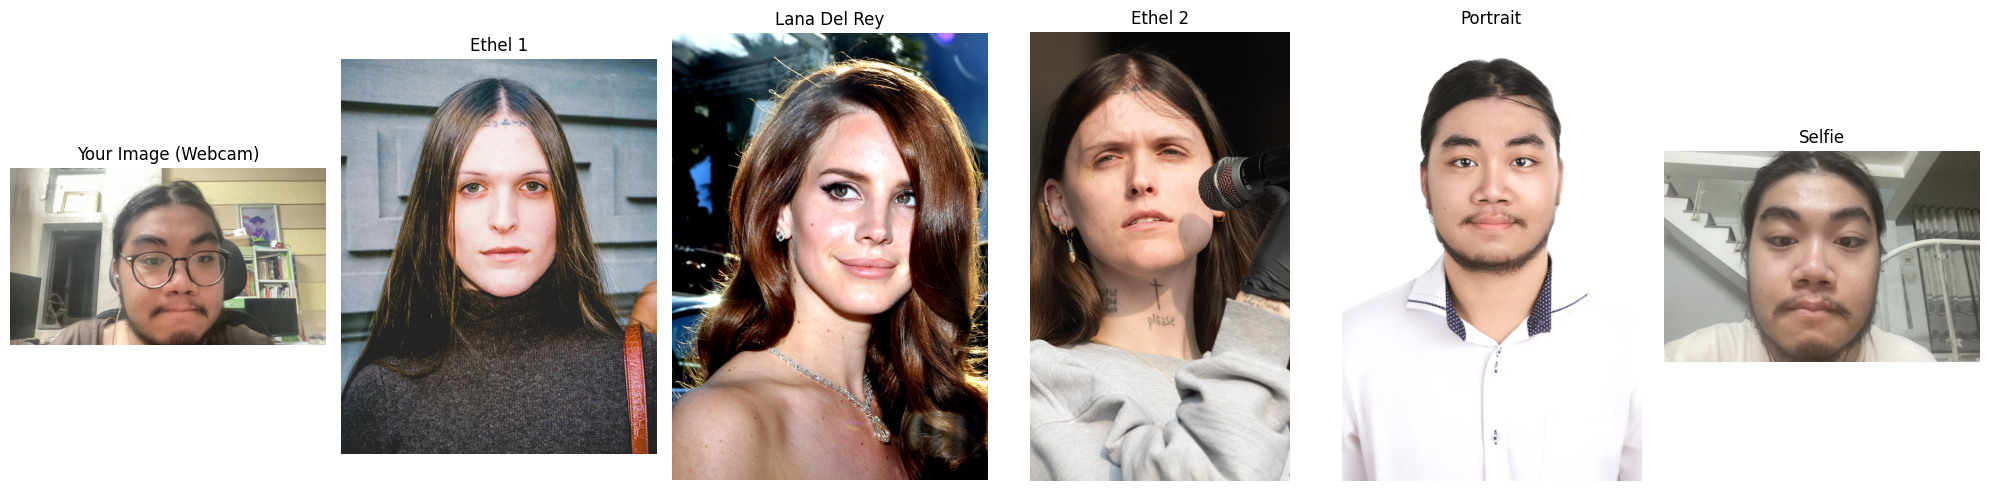


Extracting face embeddings...


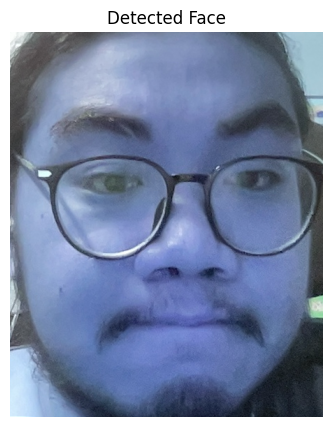

Successfully extracted embedding for Ethel 1
Successfully extracted embedding for Lana Del Rey
Successfully extracted embedding for Ethel 2
Successfully extracted embedding for Portrait
Successfully extracted embedding for Selfie
Face embedding extracted. Shape: (512,)

Plaintext cosine similarities:
You and Ethel 1: -0.3244
You and Lana Del Rey: 0.0228
You and Ethel 2: -0.0703
You and Portrait: 0.7852
You and Selfie: 0.8758

Encrypting your face embedding with TenSEAL...
Encryption complete in 0.0039 seconds!

Comparing with reference faces using FHE...
FHE Similarity with Ethel 1: -0.3244 (dot product time: 0.0115s, decrypt time: 0.0007s)
FHE Similarity with Lana Del Rey: 0.0228 (dot product time: 0.0083s, decrypt time: 0.0005s)
FHE Similarity with Ethel 2: -0.0703 (dot product time: 0.0082s, decrypt time: 0.0005s)
FHE Similarity with Portrait: 0.7852 (dot product time: 0.0083s, decrypt time: 0.0005s)
FHE Similarity with Selfie: 0.8758 (dot product time: 0.0082s, decrypt time: 0.0005

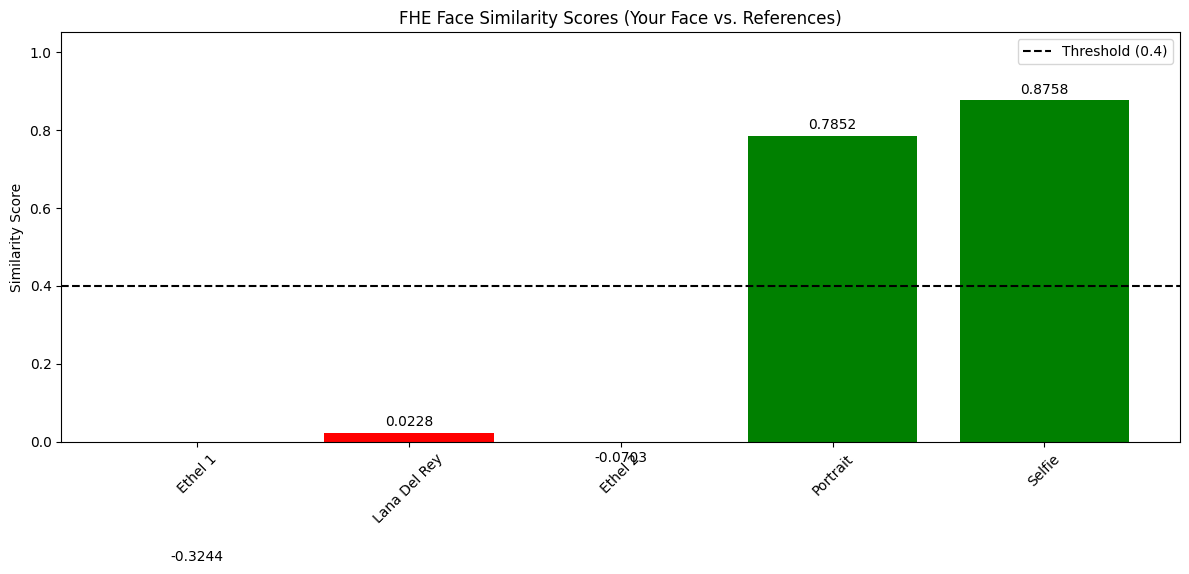


FHE vs Plaintext Comparison:
           name  fhe_similarity  plaintext_similarity         error
0       Ethel 1       -0.324399             -0.324399  4.532632e-08
1  Lana Del Rey        0.022784              0.022784  1.453867e-09
2       Ethel 2       -0.070349             -0.070349  1.088627e-08
3      Portrait        0.785183              0.785183  1.032707e-07
4        Selfie        0.875771              0.875771  1.161552e-07


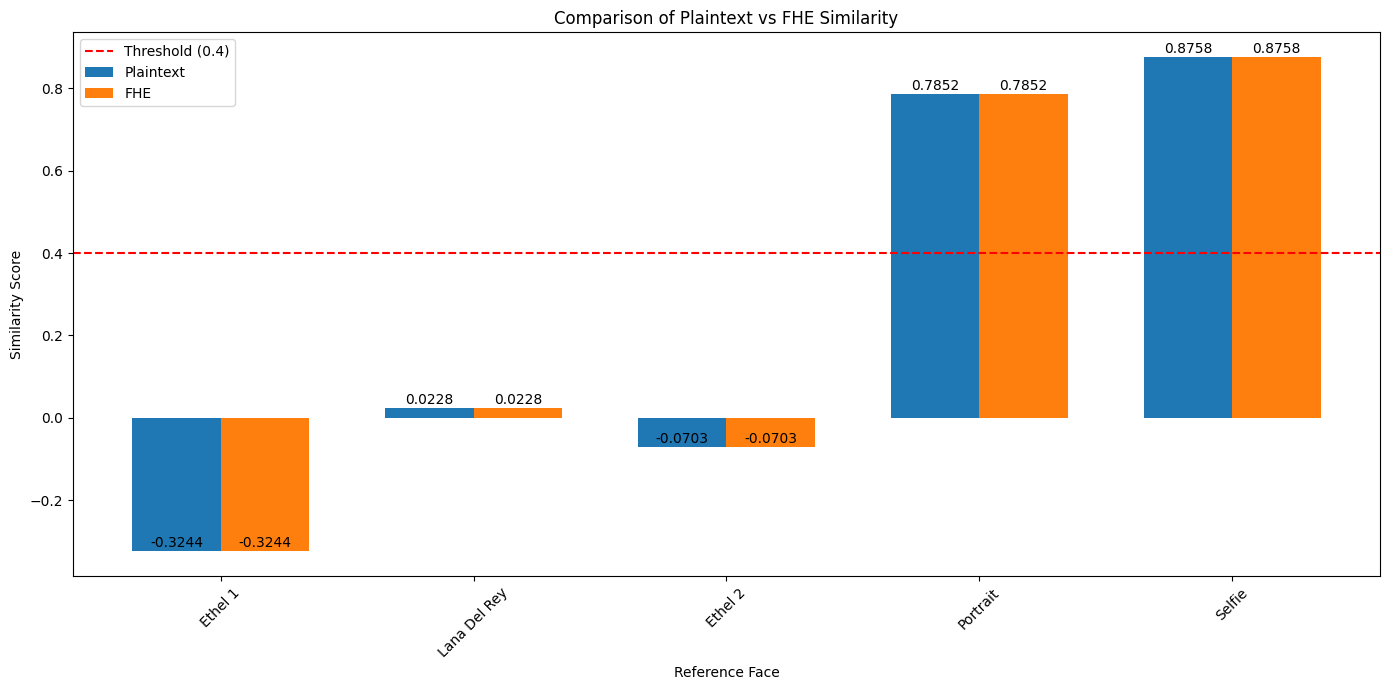


Match Summary (Sorted by FHE Score):
      Reference  Plaintext Score  FHE Score Match Status  Processing Time (s)
4        Selfie         0.875771   0.875771        MATCH             0.008756
3      Portrait         0.785183   0.785183        MATCH             0.008767
1  Lana Del Rey         0.022784   0.022784     NO MATCH             0.008814
2       Ethel 2        -0.070349  -0.070349     NO MATCH             0.008727
0       Ethel 1        -0.324399  -0.324399     NO MATCH             0.012168


In [13]:
# Cell 6: Webcam Face Verification with TenSEAL FHE (Fixed)
import cv2
import time
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def capture_from_webcam():
    """Capture an image from webcam and save it to test_images folder"""
    # Initialize webcam
    print("Initializing webcam...")
    cap = cv2.VideoCapture(0)  
    
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None
    
    # Create preview window
    cv2.namedWindow("Webcam Preview", cv2.WINDOW_NORMAL)
    
    # Wait for camera to initialize
    time.sleep(1)
    
    countdown_seconds = 3
    captured_frame = None
    
    print(f"Capturing in {countdown_seconds} seconds... Look at the camera")
    
    # Countdown loop
    for i in range(countdown_seconds, 0, -1):
        print(f"{i}...")
        
        # Capture frames during countdown
        for _ in range(10):  # Show multiple frames during each countdown second
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture frame.")
                cap.release()
                cv2.destroyAllWindows()
                return None
                
            # Display countdown on frame - but don't modify the original frame
            display_frame = frame.copy()
            cv2.putText(display_frame, str(i), (display_frame.shape[1]//2 - 50, display_frame.shape[0]//2 + 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 4)
            cv2.imshow("Webcam Preview", display_frame)
            cv2.waitKey(100)  # Small delay
    
    # Capture the final frame
    print("Smile!")
    ret, frame = cap.read()
    
    if ret:
        captured_frame = frame.copy()  # Store the clean frame without any text
        
        # Show "Captured!" message on display frame only
        display_frame = frame.copy()
        cv2.putText(display_frame, "Captured!", (display_frame.shape[1]//2 - 100, display_frame.shape[0]//2 + 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        cv2.imshow("Webcam Preview", display_frame)
        cv2.waitKey(1000)  # Show for 1 second
        
        # Save the clean image without any text
        img_path = os.path.join("test_images", "webcam_capture.jpg")
        cv2.imwrite(img_path, captured_frame)
        print(f"Image saved to {img_path}")
    else:
        print("Error: Failed to capture frame.")
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    
    return img_path if captured_frame is not None else None

# Function to calculate cosine similarity (plaintext)
def cosine_similarity(a, b):
    """Calculate cosine similarity between two vectors"""
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

# Capture image from webcam
webcam_img_path = capture_from_webcam()

if webcam_img_path is not None:
    print("\nProcessing your face image...")
    
    # Get reference images for comparison - including all five images
    reference_images = ["img1.jpg", "img2.jpg", "img3.jpg", "portrait.JPG", "selfie.jpg"]
    reference_names = ["Ethel 1", "Lana Del Rey", "Ethel 2", "Portrait", "Selfie"]
    
    # Filter to only include images that exist
    valid_ref_images = []
    valid_ref_names = []
    for i, img_file in enumerate(reference_images):
        if os.path.exists(os.path.join("test_images", img_file)):
            valid_ref_images.append(img_file)
            valid_ref_names.append(reference_names[i])
        else:
            print(f"Warning: Reference image {img_file} not found, skipping...")
    
    if not valid_ref_images:
        print("No valid reference images found. Please run the download_sample_images() function first.")
    else:
        # Display your image alongside reference images
        fig, axes = plt.subplots(1, len(valid_ref_images) + 1, figsize=(20, 5))
        
        # Your webcam image
        img = Image.open(webcam_img_path)
        axes[0].imshow(img)
        axes[0].set_title("Your Image (Webcam)")
        axes[0].axis('off')
        
        # Reference images
        for i, img_file in enumerate(valid_ref_images):
            img_path = os.path.join("test_images", img_file)
            try:
                img = Image.open(img_path)
                axes[i+1].imshow(img)
                axes[i+1].set_title(valid_ref_names[i])
                axes[i+1].axis('off')
            except Exception as e:
                print(f"Error displaying image {img_file}: {str(e)}")
        
        plt.tight_layout()
        plt.show()
        
        try:
            print("\nExtracting face embeddings...")
            
            # Choose model - Facenet512 is recommended based on your benchmarks
            model_name = "Facenet512" 
            detector = "yunet"
            
            # Extract face from webcam image for display
            webcam_faces = DeepFace.extract_faces(webcam_img_path, detector_backend=detector, enforce_detection=True)
            
            if len(webcam_faces) == 0:
                print("No face detected in your webcam image!")
            else:
                fig, ax = plt.subplots(1, 1, figsize=(5, 5))
                face_img = webcam_faces[0]['face']
                face_img_uint8 = (face_img * 255).astype("uint8") if face_img.dtype != "uint8" else face_img
                face_img_rgb = cv2.cvtColor(face_img_uint8, cv2.COLOR_BGR2RGB)
                ax.imshow(face_img_rgb)
                ax.set_title("Detected Face")
                ax.axis('off')
                plt.show()
            
            # Extract embedding from webcam image
            my_embedding = DeepFace.represent(webcam_img_path, model_name=model_name, detector_backend=detector)[0]["embedding"]
            
            # Extract embeddings for reference images
            ref_embeddings = []
            successful_ref_images = []
            successful_ref_names = []
            
            for i, img_file in enumerate(valid_ref_images):
                try:
                    img_path = os.path.join("test_images", img_file)
                    embedding = DeepFace.represent(img_path, model_name=model_name, detector_backend=detector)[0]["embedding"]
                    ref_embeddings.append((valid_ref_names[i], embedding))
                    successful_ref_images.append(img_file)
                    successful_ref_names.append(valid_ref_names[i])
                    print(f"Successfully extracted embedding for {valid_ref_names[i]}")
                except Exception as e:
                    print(f"Error extracting embedding from {valid_ref_names[i]}: {str(e)}")
            
            print(f"Face embedding extracted. Shape: {np.array(my_embedding).shape}")
            
            # First calculate plaintext cosine similarities for comparison
            plaintext_results = []
            for name, ref_embedding in ref_embeddings:
                plaintext_sim = cosine_similarity(my_embedding, ref_embedding)
                plaintext_results.append({
                    "name": name,
                    "similarity": plaintext_sim
                })
            
            print("\nPlaintext cosine similarities:")
            for result in plaintext_results:
                print(f"You and {result['name']}: {result['similarity']:.4f}")
            
            print("\nEncrypting your face embedding with TenSEAL...")
            start_time = time.time()
            my_encrypted = ts.ckks_vector(context, my_embedding)
            encryption_time = time.time() - start_time
            print(f"Encryption complete in {encryption_time:.4f} seconds!")
            
            print("\nComparing with reference faces using FHE...")
            fhe_results = []
            
            for name, ref_embedding in ref_embeddings:
                # Calculate encrypted dot product
                start_time = time.time()
                encrypted_dot = my_encrypted.dot(ref_embedding)
                dot_time = time.time() - start_time
                
                # Decrypt result
                start_time = time.time()
                decrypted_dot = encrypted_dot.decrypt()[0]
                decrypt_time = time.time() - start_time
                
                # Calculate norms (in plaintext)
                norm_my = np.linalg.norm(my_embedding)
                norm_ref = np.linalg.norm(ref_embedding)
                
                # Calculate cosine similarity
                fhe_sim = decrypted_dot / (norm_my * norm_ref)
                
                # Store results
                fhe_results.append({
                    "name": name,
                    "fhe_similarity": fhe_sim,
                    "dot_time": dot_time,
                    "decrypt_time": decrypt_time
                })
                
                print(f"FHE Similarity with {name}: {fhe_sim:.4f} (dot product time: {dot_time:.4f}s, decrypt time: {decrypt_time:.4f}s)")
                
            # Show match results
            threshold = 0.4  # Threshold for Facenet512
            
            print(f"\nUsing threshold: {threshold}")
            print("\nMatch Results:")
            
            for result in fhe_results:
                match_status = "MATCH" if result["fhe_similarity"] >= threshold else "NO MATCH"
                print(f"You and {result['name']}: {match_status} (score: {result['fhe_similarity']:.4f})")
            
            # Visualize FHE results
            if len(fhe_results) > 0:
                names = [r["name"] for r in fhe_results]
                scores = [r["fhe_similarity"] for r in fhe_results]
                
                plt.figure(figsize=(12, 6))
                bars = plt.bar(names, scores, color=['green' if s >= threshold else 'red' for s in scores])
                plt.axhline(y=threshold, color='black', linestyle='--', label=f'Threshold ({threshold})')
                
                plt.title('FHE Face Similarity Scores (Your Face vs. References)')
                plt.ylabel('Similarity Score')
                plt.ylim(0, max(max(scores) * 1.2, threshold * 1.2))
                plt.xticks(rotation=45)
                
                # Add value labels on top of bars
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{height:.4f}', ha='center', va='bottom')
                
                plt.legend()
                plt.tight_layout()
                plt.show()
                
                # Compare FHE vs Plaintext
                compare_data = []
                for i, result in enumerate(fhe_results):
                    compare_data.append({
                        "name": result["name"],
                        "fhe_similarity": result["fhe_similarity"],
                        "plaintext_similarity": plaintext_results[i]["similarity"],  # This is correct
                        "error": abs(result["fhe_similarity"] - plaintext_results[i]["similarity"])
                    })
                
                # Create comparison dataframe
                df_compare = pd.DataFrame(compare_data)
                print("\nFHE vs Plaintext Comparison:")
                print(df_compare)
                
                # Plot comparison - FIX HERE: use the correct key "similarity" from plaintext_results
                plt.figure(figsize=(14, 7))
                
                x = np.arange(len(names))
                width = 0.35
                
                # FIX: Corrected key from "plaintext_similarity" to "similarity"
                plt.bar(x - width/2, [r["similarity"] for r in plaintext_results], width, label="Plaintext")
                plt.bar(x + width/2, [r["fhe_similarity"] for r in fhe_results], width, label="FHE")
                
                plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
                plt.xlabel('Reference Face')
                plt.ylabel('Similarity Score')
                plt.title('Comparison of Plaintext vs FHE Similarity')
                plt.xticks(x, names, rotation=45)
                plt.legend()
                
                # Add value labels - FIX: Corrected key from "plaintext_similarity" to "similarity"
                for i, v in enumerate([r["similarity"] for r in plaintext_results]):
                    plt.text(i - width/2, v + 0.01, f"{v:.4f}", ha='center')
                    
                for i, v in enumerate([r["fhe_similarity"] for r in fhe_results]):
                    plt.text(i + width/2, v + 0.01, f"{v:.4f}", ha='center')
                
                plt.tight_layout()
                plt.show()
                
                # Create a summary table of all matches
                match_summary = []
                for i, result in enumerate(fhe_results):
                    match_summary.append({
                        "Reference": result["name"],
                        "Plaintext Score": plaintext_results[i]["similarity"],  # FIX: Corrected key
                        "FHE Score": result["fhe_similarity"],
                        "Match Status": "MATCH" if result["fhe_similarity"] >= threshold else "NO MATCH",
                        "Processing Time (s)": result["dot_time"] + result["decrypt_time"]
                    })
                
                df_summary = pd.DataFrame(match_summary).sort_values("FHE Score", ascending=False)
                print("\nMatch Summary (Sorted by FHE Score):")
                print(df_summary)
            else:
                print("No data to visualize. Please check the reference images.")
            
        except Exception as e:
            print(f"Error processing face embedding: {str(e)}")
            import traceback
            traceback.print_exc()
else:
    print("Failed to capture image from webcam.")